<a href="https://colab.research.google.com/github/TirmidziOthman/Diabetes-BPNN/blob/main/Diabetes_Bpnn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetesV2.csv.arff.csv")
print("Database raw shape (%s,%s)" % np.shape(data))
data

Database raw shape (768,9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.0,72.0,35.000000,105.659898,33.6,0.627,5,Diabetes
1,1.000000,85.0,66.0,29.000000,105.659898,26.6,0.351,31,Normal
2,8.000000,183.0,64.0,25.876155,105.659898,23.3,0.672,32,Diabetes
3,1.000000,89.0,66.0,23.000000,94.000000,28.1,0.167,21,Normal
4,4.165906,137.0,4.0,35.000000,168.000000,43.1,2.288,33,Diabetes
...,...,...,...,...,...,...,...,...,...
763,1.000000,11.0,76.0,48.000000,18.000000,32.9,0.171,63,Normal
764,2.000000,122.0,7.0,27.000000,105.659898,36.8,0.340,27,Normal
765,5.000000,121.0,72.0,23.000000,112.000000,26.2,0.245,3,Normal
766,1.000000,126.0,6.0,25.876155,105.659898,3.1,0.349,47,Diabetes


In [ ]:
data = pd.DataFrame(data,columns=['Pregnancies','Glucose','BloodPressure','SkinThickness'
                                  ,'Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome'])

X =  data.iloc[:,0:7].values


#replace target class with 0 and 1
data['Outcome'] = data['Outcome'].replace('Normal', 0)
data['Outcome'] = data['Outcome'].replace('Diabetes', 1)

y_label=data.iloc[:,-1].values

y_label = pd.get_dummies(y_label).values

y_label[:3]

#split data into train and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size=0.2, random_state=2)

#standardize the dataset
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")


Shape of train set is (614, 7)
Shape of test set is (154, 7)
Shape of train label is (614, 2)
Shape of test labels is (154, 2)


In [ ]:
class NeuralNet():
    '''
    A two layer neural network
    '''

    def __init__(self, layers=[7,8,2], learning_rate=0.01, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None

    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        self.params["W1"] = np.random.randn(self.layers[0], self.layers[1])
        self.params['b1']  =np.random.randn(self.layers[1],)
        self.params['W2'] = np.random.randn(self.layers[1],self.layers[2])
        self.params['b2'] = np.random.randn(self.layers[2],)

    def relu(self,Z):
        '''
        The ReLu activation function is to performs a threshold
        operation to each input element where values less
        than zero are set to zero.
        '''
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)


    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) ## clips value to avoid NaNs in log
        yhat_inv = self.eta(yhat_inv)
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''

        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)

    def acc(self, y, yhat):
        '''
        Calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y.argmax(axis=1) == yhat.argmax(axis=1)) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()

# **Model Training 1**

In [ ]:
nn = NeuralNet() # create the NN model
nn.fit(Xtrain, ytrain) #train the model

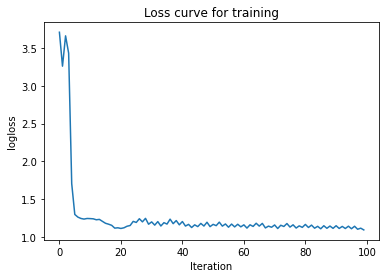

In [ ]:
nn.plot_loss()

In [ ]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)
train_acc1 = nn.acc(ytrain, train_pred)
test_acc1 = nn.acc(ytest, test_pred)

a_test_pred = test_pred

print("Train accuracy is {}%".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(nn.acc(ytest, test_pred)))

Train accuracy is 69%
Test accuracy is 76%


In [ ]:
test_pred

# **Model Training 2**

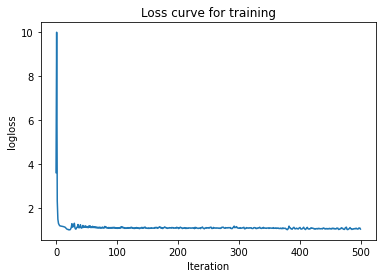

In [ ]:
nn = NeuralNet(layers=[7,10,2], learning_rate=0.01, iterations=500) # create the NN model
nn.fit(Xtrain, ytrain) #train the model
nn.plot_loss()

In [ ]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)
train_acc2 = nn.acc(ytrain, train_pred)
test_acc2 = nn.acc(ytest, test_pred)

b_test_pred = test_pred

print("Train accuracy is {}%".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(nn.acc(ytest, test_pred)))

Train accuracy is 71%
Test accuracy is 76%


# **Model Training 3**

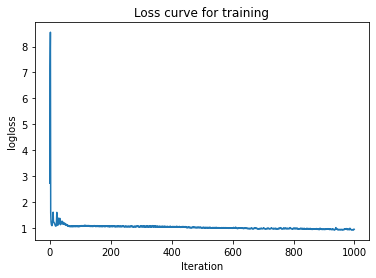

In [ ]:
nn = NeuralNet(layers=[7,12,2], learning_rate=0.01, iterations=1000) # create the NN model
nn.fit(Xtrain, ytrain) #train the model
nn.plot_loss()

In [ ]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)
train_acc3 = nn.acc(ytrain, train_pred)
test_acc3 = nn.acc(ytest, test_pred)

c_test_pred = test_pred

print("Train accuracy is {}%".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(nn.acc(ytest, test_pred)))

Train accuracy is 79%
Test accuracy is 72%


# **Model Training 4**

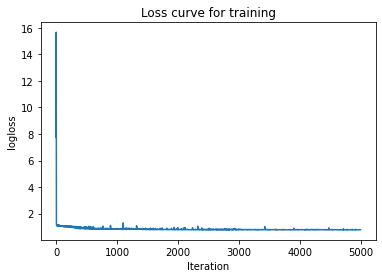

In [ ]:
nn = NeuralNet(layers=[7,20,2], learning_rate=0.01, iterations=5000) # create the NN model
nn.fit(Xtrain, ytrain) #train the model
nn.plot_loss()

In [ ]:
train_pred = nn.predict(Xtrain)
test_pred = nn.predict(Xtest)
train_acc4 = nn.acc(ytrain, train_pred)
test_acc4 = nn.acc(ytest, test_pred)

d_test_pred = test_pred

print("Train accuracy is {}%".format(nn.acc(ytrain, train_pred)))
print("Test accuracy is {}%".format(nn.acc(ytest, test_pred)))

Train accuracy is 83%
Test accuracy is 72%


# **Comparison**

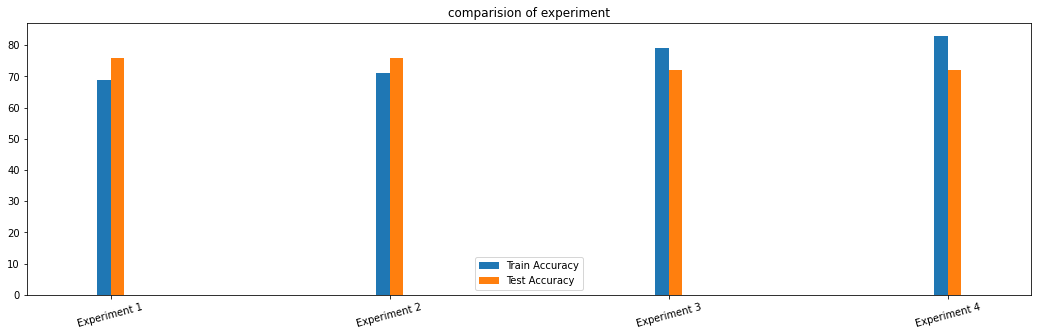

In [ ]:

# A python dictionary

data = {'Train Accuracy': [train_acc1, train_acc2, train_acc3, train_acc4],
        'Test Accuracy': [test_acc1, test_acc2, test_acc3, test_acc4]}

index     = ['Experiment 1',
                               'Experiment 2',
                               'Experiment 3',
                               'Experiment 4'];

# Dictionary loaded into a DataFrame

dataFrame = pd.DataFrame(data=data, index=index);



# Draw a vertical bar chart

dataFrame.plot.bar(rot=15, title="comparision of experiment",width = 0.1 , figsize=(18,5));
plt.show(block=True);

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(np.asarray(ytest).argmax(axis=1), b_test_pred.argmax(axis=1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[106   3]
 [ 33  12]]


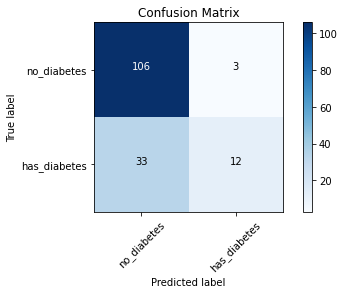

In [ ]:
cm_plot_labels = ['no_diabetes', 'has_diabetes']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')